# Le problème

Pour garantir l'équilibre offre-demande à chaque instant, RTE construit ses propres prévisions de la consommation nationale, régionale, et locale. 

Nous nous concentrons ici sur la prévision nationale. Un challenge lancé par RTE (https://dataanalyticspost.com/wp-content/uploads/2017/06/Challenge-RTE-Prevision-de-Consommation.pdf) a permis de tester des approches alternatives aux modèles internes (POPCORN, PREMIS).

<img src="pictures/ChallengeConso.png" width=1000 height=100>

Comme dans ce challenge, nous voulons aider RTE à faire de meilleures prévisions de conso ! 

## Un outil: le Machine Learning

Pour cela, nous allons avoir recours au Machine Learning. Cela nous permettra de créer un modèle qui apprend et s'adapte au contexte sans programmer un système expert avec des "centaines" de règles en dur, par de la programmation logique. 

Le Machine Learning nécessite toutefois de la connaissance experte dans le domaine d'intérêt pour créer des modèles pertinents et efficaces. En effet, si notre modèle embarque trop de variables peu explicatives, il sera noyé dans l'information, surapprendra sur les exemples qu'on lui a montrés, et aura du mal à généraliser en prédisant avec justesse sur de nouveaux exemples. 

## Une difficulté: le feature engineering

Au-delà de la simple sélection de variables pertinentes, on fait surtout ce que l'on appelle du feature engineering avec notre expertise: on crée des variables transformées ou agrégées, comme une consommation moyenne sur le mois précédent ou une température moyenne sur la France, pour guider l'algorithme et l'aider à apprendre sur l'information la plus pertinente et synthétique. Cela implique de bien connaître nos données, de passer du temps à les visualiser, et de les prétraiter avant de les fournir au modèle de machine-learning.

Nous allons ici voir ce que cela implique en terme de développement et d'implémentation de participer à un tel challenge, en montrant les capacités du Machine Learning sur la base de modèles "classiques".

## Ce que l'on va voir dans ce premier TP :
1) Formaliser le problème: que souhaite-t-on prédire (quel est mon Y) ? Avec quelles variables explicatives (quel est mon X) ?

2) Collecter les données: où se trouvent les données ? Quel est le format ? Comment les récupérer ? (FACULTATIF - voir TP "TP1_Preparation_donnees")

3) Investiguer les données: visualiser des séries temporelles, faire quelques statistiques descriptives

4) Préparer les données: pour entrainer et tester un premier modèle

5) Créer et entrainer un premier modèle simple: ce sera notre baseline

6) Evaluer un modèle

7) Itérer en créant de nouveaux modèles avec de nouvelles variables explicatives

8) Jouez: créer vos propres modèles, tester sur une saison différente, tester sur une région différente, faire une prévision avec incertitudes, détecter des outliers

## To be continued
Le deuxième TP permettra d'investiguer les modèles "Deep" avec réseaux de neurones, en montrant le moindre besoin en feature engineering et leur plus grande capacité à absorber l'information grâce aux représentations hiérarchiques qu'ils créent.

## Dimensionnement en temps
On prévoit un une durée d'environ 2h pour ce TP1, debrief inclus :
- 20-30 minutes pour charger et préparer les données [FACULTATIF]
- 30-40 minutes pour analyser et visualiser les données
- 45-60 minutes pour créer, entrainer, évaluer et interpréter les modèles

## Se familiariser avec le problème: Eco2mix
Quand on parle de courbe de consommation France, il y a une application incontournable : eco2mix !
Allons voir à quoi ressemblent ces courbes de consommation, pour nous faire une idée du problème et se donner quelques intuitions:
http://www.rte-france.com/fr/eco2mix/eco2mix
ou sur application mobile

# On passe au code : import de librairies et configuration

** L'aide de python est accessible en tapant help(nom_de_la_commande) **

## Chargement des Librairies

In [26]:
# Exécutez la cellule ci-dessous (par exemple avec shift-entrée)
# Si vous exécuter ce notebook depuis votre PC, il faudra peut-etre installer certaines librairies avec 
# 'pip install ma_librairie'
import os  # accès aux commandes système
import datetime  # structure de données pour gérer des objets calendaires
import pandas as pd  # gérer des tables de données en python
import numpy as np  # librairie d'opérations mathématiques
import matplotlib.pyplot as plt  # tracer des visualisations
import sklearn  # librairie de machine learning
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from math import sqrt

import shutil  # move ou copier fichier
import zipfile  # compresser ou décompresser fichier
import urllib3 # téléchargement de fichier

from bokeh.palettes import inferno
from bokeh.io import show, output_notebook
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, PanTool, WheelZoomTool, BoxSelectTool, ColorBar, LogTicker,
    LabelSet, Label,HoverTool
)
from bokeh.models.mappers import LogColorMapper
from collections import OrderedDict

import seaborn as sns

%matplotlib inline

%autosave 0

Autosave disabled


## Configuration
Choix du répertoire de travail "data_folder" dans lequel tous les fichiers csv seront entreposés

In [52]:
data_folder = os.path.join(os.getcwd(), "data")

In [53]:
# Petite vérification
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : D:\Users\montuelleluc\Documents\Etudes\Formations-RTE\MOOC IA&DeepLearning\TP_Formation_Conso_DeepLearning\data
Fichiers contenus dans ce répertoire :
 - communes_coordonnees.csv
 - eCO2mix_RTE_tempo_2017-2018.xls
 - joursFeries.csv
 - meteoX_T0_T24.zip
 - StationsMeteoRTE.csv
 - Xinput.csv
 - Xinput.zip
 - Xtemperature.csv
 - Yconso.csv
 - YconsoT0.csv
 - Yconso_2014_2018.csv


# Récupération des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python.
Les données brutes ont été pré-traitées à l'aide du notebook TP1_Preparation_donnees :
- Yconso.csv
- Xinput.csv

In [54]:
Yconso_csv = os.path.join(data_folder, "Yconso.csv")
Yconso = pd.read_csv(Yconso_csv)

La colonne "ds" contient des objets de type string. On va la convertir en objets de type "datetime" plus approprié.  
Pour plus d'information, voir le TP1_Preparation_donnees.

In [55]:
Yconso['ds'] = pd.to_datetime(Yconso['ds'])

In [56]:
print(Yconso.head(5))
print(Yconso.shape)

                   ds      y
0 2014-01-08 00:00:00  62008
1 2014-01-08 01:00:00  57298
2 2014-01-08 02:00:00  56216
3 2014-01-08 03:00:00  53719
4 2014-01-08 04:00:00  51798
(43368, 2)


**Attention : Les données Xinput sont encryptées dans un fichier zip. du fait de données météo**  
Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE.

In [60]:
Xinput_zip = os.path.join(data_folder, "Xinput.zip")

In [61]:
password = "FIFA"

In [62]:
# Pour travailler avec les fichiers zip, on utilise la bibliothèque **zipfile**.
zipfile_xinput = zipfile.ZipFile(Xinput_zip)
zipfile_xinput.setpassword(bytes(password,'utf-8'))
Xinput = pd.read_csv(zipfile_xinput.open('Xinput.csv'),sep=",",engine='c',header=0)

Xinput['ds'] = pd.to_datetime(Xinput['ds'])
Xinput = Xinput[[s for s in Xinput.columns.get_values() if 'X' not in s]]

RuntimeError: Bad password for file 'Xinput.csv'

In [35]:
print(Xinput.head(35))
print(Xinput.shape)
print(Xinput.columns)

                    ds holiday  FranceTh_real_24h_avant  FranceTh_prev
0  2012-12-29 00:00:00     NaN                 9.339850      10.734500
1  2012-12-29 01:00:00     NaN                 9.339580      10.735110
2  2012-12-29 02:00:00     NaN                 9.337955      10.733485
3  2012-12-29 03:00:00     NaN                 9.338565      10.733050
4  2012-12-29 04:00:00     NaN                 9.337475      10.731165
5  2012-12-29 05:00:00     NaN                 9.335850      10.730180
6  2012-12-29 06:00:00     NaN                 9.332855      10.728010
7  2012-12-29 07:00:00     NaN                 9.332975      10.725145
8  2012-12-29 08:00:00     NaN                 9.332275      10.721535
9  2012-12-29 09:00:00     NaN                 9.327870      10.717750
10 2012-12-29 10:00:00     NaN                 9.325125      10.714975
11 2012-12-29 11:00:00     NaN                 9.322740      10.709655
12 2012-12-29 12:00:00     NaN                 9.318945      10.704470
13 201

# Visualisation des données 

La DataScience et le Machine Learning supposent de bien appréhender les données sur lesquelles nos modèles vont être entrainés. Pour cela, il est utile de faire des statistiques descriptives et des visualisations de nos différentes variables.

Traitant d'un problème de prévision, on visualisera en particulier des séries temporelles.

Vous allez voir des :
- échantillons de données
- profils de courbe de consommation journaliers et saisonniers
- visualisations de corrélation entre conso J et conso retardée
- visualisations des séries temporelles des températures
- calculs de corrélations entre la température et les différentes stations météo

## Calcul de statistiques descriptives sur la consommation nationale
A l'aide de la fonction _describe_.

In [36]:
Yconso['y'].describe()

count    43368.000000
mean     54010.378574
std      11837.807039
min      29477.000000
25%      45025.250000
50%      52422.000000
75%      62167.000000
max      95987.000000
Name: y, dtype: float64

In [37]:
Yconso['y'].isnull().sum()

0

## Visualiser la consommation d'un jour particulier
On souhaite visualiser la consommation réalisée pour un jour donné de l'historique.

In [38]:
def plot_load(var_load, year, month, day):
    date_cible = datetime.datetime(year=year, month=month, day=day)  # implicitement heure = minuit
    date_lendemain_cible = date_cible + datetime.timedelta(days=1)
    mask = (var_load.ds >= date_cible) & (var_load.ds <= date_lendemain_cible)   
    consoJour = var_load[mask]
    plt.plot(consoJour['ds'], consoJour['y'], color='blue')
    plt.show()

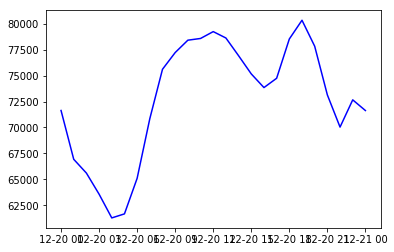

In [39]:
plot_load(Yconso, 2016, 12, 20)

## Afficher une semaine arbitraire de consommation
On pourra modifier la fonction précédente en rajoutant le timedelta en paramètre.

In [40]:
def plot_load_timedelta(var_load, year, month, day, delta_days):
    date_cible = datetime.datetime(year=year, month=month, day=day)
    date_lendemain_cible = date_cible + datetime.timedelta(days=delta_days)

    conso_periode = var_load[(var_load.ds >= date_cible) 
                                      & (var_load.ds <= date_lendemain_cible)]
    plt.plot(conso_periode['ds'], conso_periode['y'], color='blue')
    plt.show()

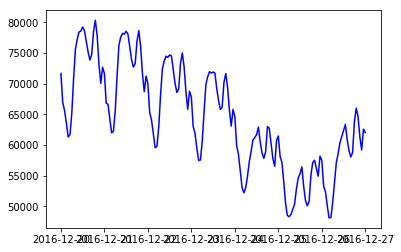

In [41]:
plot_load_timedelta(Yconso, 2016, 12, 20, delta_days=7)

## Observation des profils de la consommation pour les mois d'hiver et les mois d'été
Toujours dans le but d'appréhender nos données, on va regarder les profils moyens pour les mois d'été et pour ceux d'hiver. On va également observer le min et le max pour avoir une idée de la variabilité du signal.

In [42]:
# Par commodité, on isole le mois pour après attraper les mois d'hiver et d'été
Xinput['month'] = Xinput['ds'].dt.month

# On isole aussi les heures
Xinput['hour'] = Xinput['ds'].dt.hour

# On sépare les jours de la semaine en week-end / pas week-end
# De base, la fonction datetime.weekday() renvoie 0 => Lundi, 2 => Mardi, ..., 5 => Samedi, 6 => Dimanche
# Ci-dessous, si on a un jour d ela semaine alors dans la colonne weekday on mettra 1, et 0 si c'est le week-end
Xinput['weekday'] = (Xinput['ds'].dt.weekday < 5).astype(int)  # conversion bool => int

In [43]:
Xinput.head(5)

,ds,holiday,FranceTh_real_24h_avant,FranceTh_prev,month,hour,weekday
0,2012-12-29 00:00:00,NaN,9.339850,10.734500,12,0,0
1,2012-12-29 01:00:00,NaN,9.339580,10.735110,12,1,0
2,2012-12-29 02:00:00,NaN,9.337955,10.733485,12,2,0
3,2012-12-29 03:00:00,NaN,9.338565,10.733050,12,3,0
4,2012-12-29 04:00:00,NaN,9.337475,10.731165,12,4,0


In [44]:
# On aggrège les mois d'hiver ensemble
XY_df = pd.merge(Yconso, Xinput, on = 'ds')
groupedHiver = XY_df[(XY_df.month == 12) | 
                                     (XY_df.month == 1) | 
                                     (XY_df.month == 2)].groupby(['weekday', 'hour'], as_index=True)

# Idem pour les mois d'été
groupedEte = XY_df[(XY_df.month == 6) | 
                                   (XY_df.month == 7) | 
                                   (XY_df.month == 8)].groupby(['weekday', 'hour'], as_index=True)

statsHiver = groupedHiver['y'].aggregate([np.mean, np.min, np.max])
statsEte = groupedEte['y'].aggregate([np.mean, np.min, np.max])

In [20]:
print(statsHiver)

                      mean   amin   amax
weekday hour                            
0       0     67588.142857  52914  84120
        1     63103.890110  48866  79849
        2     61936.142857  47963  79895
        3     59319.054945  45759  77368
        4     56757.692308  43833  74752
        5     55873.142857  43520  74342
        6     56861.615385  44858  75698
        7     58599.208791  46444  77952
        8     60513.263736  48324  81395
        9     62601.626374  49467  83783
        10    64882.021978  51791  85464
        11    65576.109890  52786  84509
        12    66312.934066  53317  83314
        13    67271.824176  54316  83593
        14    63573.758242  50394  79803
        15    60990.890110  47892  76792
        16    59515.604396  46704  75135
        17    59717.450549  47935  75184
        18    63962.417582  50872  80259
        19    68619.076923  57070  82733
        20    67977.747253  56500  81352
        21    65257.516484  54213  78545
        22    62

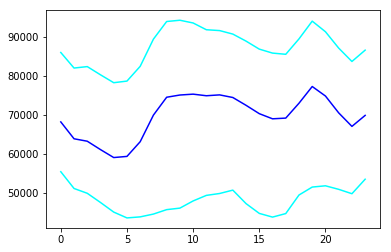

In [45]:
# On affiche des infos sur le profil pour les jours de la semaine
semaine = statsHiver.loc[1]  # 0 pour les jours de semaine
weekend = statsHiver.loc[0]  # 0 pour weekend

plt.plot(semaine['amin'], color='cyan')
plt.plot(semaine['mean'], color='blue')
plt.plot(semaine['amax'], color='cyan')
plt.show()

## Lien avec la consommation passée
A l'aide de la fonction shift, pour un point horaire cible on regarde  :
- la consommation de l'heure précédente, 
- du jour précédent, 
- de la semaine précédente.

On regarde ensuite si la consommation réalisée peut se deviner à partir de ces observations.

In [46]:
Xinput['lag1H'] = Yconso['y'].shift(1)
Xinput['lag1D'] = Yconso['y'].shift(24)
Xinput['lag1W'] = Yconso['y'].shift(24*7)

In [47]:
Xinput.head(24 * 7 + 1)

,ds,holiday,FranceTh_real_24h_avant,FranceTh_prev,month,hour,weekday,lag1H,lag1D,lag1W
0,2012-12-29 00:00:00,NaN,9.339850,10.734500,12,0,0,NaN,NaN,NaN
1,2012-12-29 01:00:00,NaN,9.339580,10.735110,12,1,0,62008.0,NaN,NaN
2,2012-12-29 02:00:00,NaN,9.337955,10.733485,12,2,0,57298.0,NaN,NaN
3,2012-12-29 03:00:00,NaN,9.338565,10.733050,12,3,0,56216.0,NaN,NaN
4,2012-12-29 04:00:00,NaN,9.337475,10.731165,12,4,0,53719.0,NaN,NaN
5,2012-12-29 05:00:00,NaN,9.335850,10.730180,12,5,0,51798.0,NaN,NaN
6,2012-12-29 06:00:00,NaN,9.332855,10.728010,12,6,0,52083.0,NaN,NaN
7,2012-12-29 07:00:00,NaN,9.332975,10.725145,12,7,0,56082.0,NaN,NaN
8,2012-12-29 08:00:00,NaN,9.332275,10.721535,12,8,0,63083.0,NaN,NaN
9,2012-12-29 09:00:00,NaN,9.327870,10.717750,12,9,0,68358.0,NaN,NaN


On regarde maintenant graphiquement si on a une belle corrélation ou non :

In [24]:
def plot_scatter_load(var_x):
    plt.scatter(Xinput[var_x],Yconso['y'])
    plt.title(var_x)
    plt.show()

ValueError: x and y must be the same size

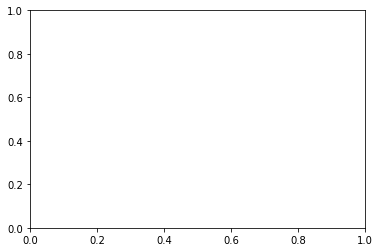

In [25]:
plot_scatter_load('lag1H')
plot_scatter_load('lag1D')
plot_scatter_load('lag1W')

### Question
Que pensez-vous de ces corrélations ?

## Visualiser la consommation en fonction de la température 
On voudrait savoir si la consommation nationale peut s'expliquer en regardant simplement la température moyenne sur la France. Pour cela, on peut tracer un nuage de points.

In [51]:
plt.scatter(Xinput['FranceTh_prev'], Yconso['y'], alpha=0.2)
plt.show()

TypeError: 'tuple' object is not callable

### Question
Que pensez-vous de ce nuage ? Est-ce suffisant ?

# Bricolage d'un modèle prédictif naïf

<img src="pictures/hommeNaif.png" width=500 height=60>

In [ ]:
# Pour se faire les dents on va considérer juste un point horaire
datetime_a_predire = datetime.datetime.strptime("2016-12-20_14:00", "%Y-%m-%d_%H:%M")
y_true_point_horaire_cible = float(Yconso.loc[Yconso['ds'] == datetime_a_predire]['y'])

print("On veut predire la consommation du {}, soit {}".format(datetime_a_predire, y_true_point_horaire_cible))

## Première idée, un modèle naïf : pour l'heure qui nous intéresse, on plaque bêtement la valeur de consommation nationale de la veille

On commence par juste notre point horaire

In [ ]:
y_pred_modele_naif_1 = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['lag1D'])
pred_error = abs(y_true_point_horaire_cible - y_pred_modele_naif_1)

print("Modele 1 -- pred: {}, realisee: {}, erreur: {}%".format(y_pred_modele_naif_1, y_true_point_horaire_cible, pred_error/y_true_point_horaire_cible * 100))

Voyons maintenant ce que ça donne non plus sur un unique point horaire mais sur l'ensemble des points horaires :

In [ ]:
y_pred_modele_naif_1 = Xinput["lag1D"]

pred_error = (np.abs(Yconso["y"] - y_pred_modele_naif_1.loc[24:]) / Yconso["y"] * 100)

print(np.mean(pred_error))

Bon c'est pas fou...

## Deuxième idée : modèle naïf avec de l'expertise métier 

Chez RTE, on considère qu'une augmentation moyenne de 1°C conduit à une augmentation de 2400MW de la consommation nationale pour des températures inférieures à 15°C. On propose donc comme consommation prévue la consommation de la veille, corrigée par 2400 fois l'écart à la température de la veille, si l'on n'excède pas les 15°C.


<img src="pictures/ExpertJamy.jpg" width=500 height=60>

In [ ]:
delta_MW_par_degre = 2400  
            
threshold_temperature = 15

On commence par juste notre point horaire préféré

In [ ]:
temperature_real_veille = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['FranceTh_real_24h_avant'])
temperature_prevu_cible = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['FranceTh_prev'])
delta_temp = min(threshold_temperature, temperature_prevu_cible) - min(threshold_temperature, temperature_real_veille)
delta_MW_because_temp = delta_temp * delta_MW_par_degre

y_pred_modele_naif_2 = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['lag1D']) - delta_MW_because_temp
pred_error = abs(y_true_point_horaire_cible - y_pred_modele_naif_2)

print("Modele 2 -- pred: {}, realisee: {}, erreur: {}%".format(y_pred_modele_naif_2, y_true_point_horaire_cible, pred_error/y_true_point_horaire_cible * 100))

Et maintenant sur l'ensemble des points horaires :

In [ ]:
y_pred = Xinput["lag1D"]

temp_prev_with_threshold = np.minimum([threshold_temperature], Xinput['FranceTh_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature], Xinput['FranceTh_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre

y_pred_modele_naif_2 = Xinput["lag1D"] - delta_MW_because_temp
pred_error = (np.abs(Yconso["y"] - y_pred_modele_naif_2) / Yconso["y"] * 100)

print(np.mean(pred_error))

Bon... Bien essayé avec ces modèles naïfs, mais maintenant on va être plus sérieux !

# Préparer un jeu d'entrainement et un jeu de test
En machine learning, il y a 2 types d'erreur que l'on peut calculer : l'erreur d'entrainement et l'erreur de test. 

Pour évaluer la capacité de notre modèle à bien généraliser sur de nouvelles données, il est très important de se préserver un jeu de test indépendant de celui d'entrainement.

Il faut donc segmenter notre dataset en 2 : 
- un premier jeu servira pour l'entrainement, 
- tandis que le second servira à mesurer les performances du modèle prédictif.

In [ ]:
def prepareDataSetEntrainementTest(Xinput, Yconso, dateDebut, dateRupture, nbJourlagRegresseur=0):
    
    dateStart = Xinput.iloc[0]['ds']
    
    DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur)+' days')  #si un a un regresseur avec du lag, il faut prendre en compte ce lag et commencer l'entrainement a la date de debut des donnees+ce lag
    XinputTest = Xinput[(Xinput.ds >= dateRupture)]    

    XinputTrain=Xinput[(Xinput.ds < dateRupture) & (Xinput.ds > DateStartWithLag) & (Xinput.ds > dateDebut)]
    YconsoTrain=Yconso[(Yconso.ds < dateRupture) & (Yconso.ds > DateStartWithLag) & (Yconso.ds > dateDebut)]
    YconsoTest=Yconso[(Xinput.ds >= dateRupture)]
    
    return XinputTrain, XinputTest, YconsoTrain, YconsoTest

# Fonctions utilitaires

Créons la fonction modelError qui va calculer pour un échantillon (Y, Y_hat) différents scores :
- erreur relative moyenne (MAPE en %)
- erreur relative max (en %)
- rmse (en MW)


In [ ]:
def modelError(Y, Yhat):

    Y = Y.reset_index(drop=True)
    
    relativeErrorsTest = np.abs((Y['y'] - Yhat) /Y['y']) 
    errorMean = np.mean(relativeErrorsTest)
    errorMax = np.max(relativeErrorsTest)
    rmse = np.sqrt(mean_squared_error(Y['y'], Yhat))
   
    return relativeErrorsTest, errorMean, errorMax, rmse

In [ ]:
def evaluation(YTrain, YTest, YTrainHat, YTestHat):
    # Ytrain et Ytest ont deux colonnes : ds et y
    # YtrainHat et YTestHat sont des vecteurs
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTest, YTestHat)
    print("l'erreur relative moyenne de test est de:" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de test est de:" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de:' + str(round(RMSETest,0)))
    print()
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTrain, YTrainHat)
    print("l'erreur relative moyenne de train est de:" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de train est de:" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de:' + str(round(RMSETest,0))) 

In [ ]:
def evaluation_par(X, Y, Yhat,avecJF=True):
    Y['weekday'] = Y['ds'].dt.weekday
    Y['hour'] = Y['ds'].dt.hour
    if(avecJF):
        Y['JoursFeries'] = X['JoursFeries']
    Y['APE'] = np.abs(Y['y']-Yhat)/Y['y']
    dataWD = Y[['weekday','APE']]
    groupedWD = dataWD.groupby(['weekday'], as_index=True)
    statsWD = groupedWD.aggregate([np.mean])
    dataHour = Y[['hour','APE']]
    groupedHour = dataHour.groupby(['hour'], as_index=True)
    statsHour = groupedHour.aggregate([np.mean])
    
    if(avecJF):
        dataJF = Y[['JoursFeries','APE']]
        groupedJF = dataJF.groupby(['JoursFeries'], as_index=True)
        statsJF = groupedJF.aggregate([np.mean])
    else:
        statsJF = None
    
    return statsWD, statsHour, statsJF

## Preparation de Xinput

In [ ]:
Xinput = Xinput.drop(['lag1H'],axis=1)  # on supprime la consommation retardée d'une heure, non disponible pour notre exercice de prévision

In [ ]:
print(Xinput.shape)
print(Xinput.columns)

On encode les données calendaires en one-hot encoding pour le modèle.
Cet encodage est nécessaire pour que le modèle mathématique puisse appréhender la notion de date.

In [ ]:
encodedWeekDay = pd.get_dummies(Xinput['weekday'],prefix="weekday")
encodedMonth = pd.get_dummies(Xinput['month'],prefix="month")
encodedHour = pd.get_dummies(Xinput['hour'],prefix="hour")

In [ ]:
encodedWeekDay.head(3)

In [ ]:
encodedMonth.head(3)

In [ ]:
encodedHour.head(3)

In [ ]:
Xinput = pd.concat([Xinput, encodedMonth, encodedWeekDay, encodedHour], axis=1)
Xinput = Xinput.drop(['month','weekday','hour'],axis=1)

In [ ]:
print(Xinput.shape)
print(Xinput.columns)

In [ ]:
# Récupération des prévisions météo à J+1 pour la veille
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th_prev' in s]
lag_colsToKeepWeather = [ s + "_J_1" for s in colsToKeepWeather ]
Xinput[lag_colsToKeepWeather] = Xinput[colsToKeepWeather].shift(24)
time = pd.to_datetime(Xinput['ds'], yearfirst=True)
Xinput['posan']= time.dt.dayofyear

In [ ]:
#Récupération des jours fériés dans Xinput
encodedHolidays = pd.get_dummies(Xinput[['holiday']], prefix = "JF")
encodedHolidays['JoursFeries'] = encodedHolidays.sum(axis = 1)
Xinput = pd.concat([Xinput, encodedHolidays], axis = 1)
Xinput = Xinput.drop(['holiday'], axis = 1)

On ajoute des températures seuillées, à 15°C pour l'effet chauffage, et à 18°C pour l'effet climatisation.

In [ ]:
threshold_temperature_heat = 15
threshold_temperature_cool = 18

Xinput['temp_prev_with_threshold_heat'] = np.maximum(0, threshold_temperature_heat - Xinput['FranceTh_prev'].values)
Xinput['temp_prev_with_threshold_cool'] = np.maximum(0, Xinput['FranceTh_prev'].values - threshold_temperature_cool)

In [ ]:
#affichage de toutes les variables de base
list(Xinput) #list plutôt que print pour avoir la liste complète

Enfin, nous construisons les listes pour appeler plus rapidement les colonnes d'un même type.

In [ ]:
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th_prev' in s]
colsToKeepMonth = [v for v in Xinput.columns.get_values() if 'month' in v]
colsToKeepWeekday = [v for v in Xinput.columns.get_values() if 'weekday' in v]
colsToKeepHour = [v for v in Xinput.columns.get_values() if 'hour' in v]
colsToKeepHolidays = [v for v in Xinput.columns.get_values() if 'JF_' in v]

# Construction des jeux d'entrainement et de test

In [ ]:
# on souhaite un jeu de test qui commence à partir du 1er mai 2017
dateDebut = datetime.datetime(year=2013, month=1, day=7)#pour éviter les NaN dans le jeu de données
dateRupture = datetime.datetime(year=2017, month=5, day=1)#début du challenge prevision de conso
nbJourlagRegresseur = 0

In [ ]:
XinputTrain, XinputTest, YconsoTrain, YconsoTest = prepareDataSetEntrainementTest(Xinput, Yconso, 
                                                                                  dateDebut, dateRupture, 
                                                                                  nbJourlagRegresseur)

In [ ]:
print('la taille de l échantillon XinputTrain est:' + str(XinputTrain.shape))
print('la taille de l échantillon XinputTest est:' + str(XinputTest.shape))
print('la taille de l échantillon YconsoTrain est:' + str(YconsoTrain.shape))
print('la taille de l échantillon YconsoTest est:' + str(YconsoTest.shape))
print("la proportion de data d'entrainement est de:" + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] + YconsoTest.shape[0])))


# Régression linéaire simple

Le modèle naïf avec expertise métier a été inspiré de la forme de la courbe d'évolution de la consommation en fonction de la température en France. 
Pour rappel:

In [ ]:
plt.scatter(Xinput['FranceTh_prev'], Yconso['y'], alpha=0.2)
plt.show()

La consommation pourrait être modélisée par une fonction linéaire par morceaux de la température, avec une pente plus importante pour les températures froides que pour les températures élevées. Au lieu de fixer les gradients à 2400MW/°C et 0, ceux-ci pourraient être calibrés à partir des données.


## Entrainer un modèle
Notre modèle a des paramètres qu'il va falloir maintenant apprendre au vu de notre jeu d'entrainement. Il faut donc caler notre modèle sur ce jeu d'entrainement.

In [ ]:
colsLR_simple = np.concatenate(([s for s in XinputTrain.columns.get_values() if 'temp_prev_with_' in s], colsToKeepHour, colsToKeepWeekday, colsToKeepMonth))

mTrain = linear_model.LinearRegression(fit_intercept = False)

In [ ]:
mTrain.fit(XinputTrain[colsLR_simple], YconsoTrain[['y']])
print('Coefficients: \n', mTrain.coef_)

## Faire des prédictions
Une fois qu'un modèle de prévision est entrainé, il ne s'avère utile que s'il est performant sur de nouvelles situations. Faisons une prévision sur notre jeu de test.

In [ ]:
forecastTest = np.concatenate(mTrain.predict(XinputTest[colsLR_simple]))
forecastTrain = np.concatenate(mTrain.predict(XinputTrain[colsLR_simple]))

In [ ]:
# on visualise nos previsions 

plt.scatter(forecastTest, YconsoTest[['y']])
plt.show()

plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

## Interpreter le modèle 
Au vu des visualisations précédentes :
- quelles interprétations pouvez-vous faire du modèle?
- Comment varie le comportement de la courbe de consommation?

## Evaluer l'erreur de prévision
Quelle est la performance de notre modèle sur ce jeu de test ?

In [ ]:
evaluation(YconsoTrain, YconsoTest, forecastTrain,  forecastTest)

## Enquêter autour des erreurs de prévision

### Evaluation en fonction du jour de semaine, de l'heure, si jour férié ou non

### Comment se distribue l'erreur ?

In [ ]:
erreur_relative_test, erreur_moyenne_test, erreur_max_test, rmse = modelError(YconsoTest, forecastTest)

In [ ]:
num_bins = 100
plt.hist(erreur_relative_test, num_bins)
plt.show()

### A quel moment se trompe-t-on le plus ?

In [ ]:
plt.plot(YconsoTest['ds'], erreur_relative_test, 'r')
plt.title("erreur relative sur la periode de test")
plt.show()

In [ ]:
erreur_relative_test.head()

In [ ]:
threshold = 0.18

mask = (erreur_relative_test >= threshold)
forecastTest['ds'].loc[mask] #### ne marche pas

## Feature engineering
Quelles variables explicatives peuvent nous permettre de créer un modele plus perfomant ?

# Autres modèles : RandomForest et XGBoost

## Modèle RandomForest

<img src="pictures/randomForestExplain.png" width=500 height=30>

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### Préparation des données d'entrée

In [ ]:
colsRF = np.concatenate((['lag1D','lag1W','JoursFeries'],
                         colsToKeepWeather,colsToKeepMonth,colsToKeepWeekday,colsToKeepHour))
list(colsRF)

### Entrainement du modèle

In [ ]:
# La cellule peut prendre un peu de temps à exécuter
rfTrain = RandomForestRegressor(n_estimators=30, max_features=colsRF.size, n_jobs=3, oob_score = True, bootstrap = True)
rfTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])

### Prediction

In [ ]:
forecastTest = rfTrain.predict(XinputTest[colsRF])
forecastTrain = rfTrain.predict(XinputTrain[colsRF])

### Evaluation

In [ ]:
evaluation(YconsoTrain, YconsoTest, forecastTrain, forecastTest)

# on visualise nos previsions par rapport a la realité
plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rfTrain.score(XinputTrain[colsRF], YconsoTrain['y']), 
                                                                                             rfTrain.oob_score_,
rfTrain.score(XinputTest[colsRF], YconsoTest['y'])))

In [ ]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTest)
print(str(round(evalWD*100,1)))
print(str(round(evalHour*100,1)))
print(str(round(evalJF*100,1)))

## Modèle xgboost

<img src="pictures/XGboost.png" width=500 height=30>

In [ ]:
import xgboost as xgb

In [ ]:
xgbTrain = xgb.XGBRegressor( )
xgbTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])
forecastTestXGB = xgbTrain.predict(XinputTest[colsRF])
forecastTrainXGB = xgbTrain.predict(XinputTrain[colsRF])

In [ ]:
evaluation(YconsoTrain, YconsoTest, forecastTrainXGB, forecastTestXGB)

In [ ]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest, YconsoTest, forecastTestXGB)
print(str(round(evalWD * 100,1)))
print(str(round(evalHour * 100,1)))
print(str(round(evalJF * 100,1)))

### Question
- Selon vous, pourquoi l'erreur max est significative pour tous les modèles ?
- Comment y remédier ?

# Bonus: à vous de jouer

Bravo ! Vous avez déjà créé un premier modèle performant pour faire des prévisions sur une fenêtre glissante à horizon 24h !

Maintenant à vous de mettre votre expertise pour créer de nouveaux modèles.

Vous pouvez continuer à explorer le problème selon plusieurs axes:
- créer des modèles pour les régions françaises
- tester votre modèle sur une autre saison (l'hiver par exemple)
- créer de nouvelles variables explicatives ? Quid de la météo et de la température? Des jours fériés ? Du feature engineering plus complexe...
- détecter des outliers dans les données
- etudiez les incertitudes et les possibilités offertes par PyStan

Mettez-vous en 3 groupes, explorez pendant 30 minutes, et restituez.